In [2]:
import matplotlib.pyplot as plt
import pandas as pd
path = "Global_Cybersecurity_Threats_2015-2024.csv"
# Load the dataset
df_true = pd.read_csv(path)
print(df_true.head())

   Country  Year        Attack Type     Target Industry  \
0    China  2019           Phishing           Education   
1    China  2019         Ransomware              Retail   
2    India  2017  Man-in-the-Middle                  IT   
3       UK  2024         Ransomware  Telecommunications   
4  Germany  2018  Man-in-the-Middle                  IT   

   Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                          80.53                    773169  Hacker Group   
1                          62.19                    295961  Hacker Group   
2                          38.65                    605895  Hacker Group   
3                          41.44                    659320  Nation-state   
4                          74.41                    810682       Insider   

  Security Vulnerability Type Defense Mechanism Used  \
0          Unpatched Software                    VPN   
1          Unpatched Software               Firewall   
2              Weak 

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

print("="*60)
print("DATA CLEANING CORREGIDO - SIN MODIFICAR CATEGORÍAS")
print("="*60)

# Asumiendo que df_true es tu DataFrame original
df = df_true.copy()
print(f"Shape inicial: {df.shape}")

# ============================================
# 1. VERIFICACIÓN INICIAL SIN MODIFICAR DATOS
# ============================================
print("\n" + "="*50)
print("1. VERIFICACIÓN INICIAL (SIN MODIFICAR)")
print("="*50)

print("\n🔍 VALORES NULOS INICIALES:")
print(df.isnull().sum())

print("\n🔍 DUPLICADOS INICIALES:")
print(f"Filas duplicadas: {df.duplicated().sum()}")

# ============================================
# 2. LIMPIEZA CONSERVADORA DE NULOS
# ============================================
print("\n" + "="*50)
print("2. LIMPIEZA DE NULOS (CONSERVADORA)")
print("="*50)

# Solo eliminar filas completamente nulas
initial_shape = df.shape[0]
df = df.dropna(how='all')
print(f"Filas después de eliminar completamente nulas: {df.shape[0]}/{initial_shape}")

# Imputar nulos mínimamente
categorical_cols = ['Country', 'Attack Type', 'Target Industry', 
                   'Attack Source', 'Security Vulnerability Type', 
                   'Defense Mechanism Used']

numeric_cols = ['Year', 'Financial Loss (in Million $)', 
                'Number of Affected Users', 'Incident Resolution Time (in Hours)']

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in categorical_cols:
            df[col] = df[col].fillna('Unknown')
        elif col in numeric_cols:
            df[col] = df[col].fillna(df[col].median())
        print(f"✓ Nulos imputados en {col}: {df[col].isnull().sum()} restantes")

# ============================================
# 3. LIMPIEZA DE TEXTO MÍNIMA (SOLO ESPACIOS)
# ============================================
print("\n" + "="*50)
print("3. LIMPIEZA DE TEXTO (MÍNIMA)")
print("="*50)

# SOLO limpiar espacios, NO cambiar mayúsculas
for col in categorical_cols:
    if col in df.columns:
        # Solo espacios, preservar case original
        df[col] = df[col].astype(str).str.strip()
        
        # Verificar valores únicos ORIGINALES
        unique_values = df[col].nunique()
        print(f"✓ {col}: {unique_values} valores únicos (case preservado)")

# ============================================
# 4. VERIFICACIÓN DE DATOS ORIGINALES
# ============================================
print("\n" + "="*50)
print("4. VERIFICACIÓN DE DATOS ORIGINALES")
print("="*50)

print("\n🎯 DISTRIBUCIÓN ORIGINAL DE Attack Type:")
print(df['Attack Type'].value_counts())

print("\n🎯 VALORES ÚNICOS EN CADA CATEGORÍA:")
for col in categorical_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        print(f"\n{col} ({len(unique_vals)} valores):")
        print(unique_vals[:10])  # Mostrar solo primeros 10

# ============================================
# 5. DETECCIÓN DE POSIBLES PROBLEMAS
# ============================================
print("\n" + "="*50)
print("5. DETECCIÓN DE PROBLEMAS POTENCIALES")
print("="*50)

# Verificar si hay datos sintéticos
print("\n🔍 ANÁLISIS DE PATRONES:")

# 1. Verificar si las variables son independientes
print("1. Relación Country vs Attack Type:")
ct_country_attack = pd.crosstab(df['Country'], df['Attack Type'], normalize='index')
max_variation = ct_country_attack.max(axis=1).std()
print(f"   Variación máxima: {max_variation:.4f} (baja = sin relación)")

# 2. Verificar distribución uniforme (señal de datos sintéticos)
print("2. Distribución de Attack Type:")
attack_dist = df['Attack Type'].value_counts(normalize=True)
uniformity_score = attack_dist.std()  # Baja desviación = distribución uniforme
print(f"   Score de uniformidad: {uniformity_score:.4f} (bajo = posible sintético)")

# 3. Verificar si hay relaciones lógicas
print("3. Relación Industry vs Attack Type:")
industry_attack = df.groupby('Target Industry')['Attack Type'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Mixed')
print("   Ataque más común por industria:")
for industry, attack in industry_attack.items():
    print(f"   - {industry}: {attack}")

# ============================================
# 6. DIAGNÓSTICO DE CALIDAD DE DATOS
# ============================================
print("\n" + "="*50)
print("6. DIAGNÓSTICO DE CALIDAD")
print("="*50)

# Test de aleatoriedad
try:
    # Test de independencia entre Country y Attack Type
    chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df['Country'], df['Attack Type']))
    print(f"\n🔬 TEST ESTADÍSTICO DE INDEPENDENCIA:")
    print(f"   p-value: {p_value:.6f}")
    print(f"   Interpretación: {'INDEPENDIENTES (datos sintéticos?)' if p_value > 0.05 else 'DEPENDIENTES (datos reales?)'}")
except Exception as e:
    print(f"❌ No se pudo realizar test estadístico: {e}")

# ============================================
# 7. RESUMEN FINAL
# ============================================
print("\n" + "="*50)
print("7. RESUMEN FINAL - DIAGNÓSTICO")
print("="*50)

print(f"\n📊 DATASET FINAL: {df.shape}")
print(f"📊 Valores nulos: {df.isnull().sum().sum()}")

print(f"\n🎯 DISTRIBUCIÓN CLAVE:")
print(f"   Attack Types: {df['Attack Type'].nunique()} tipos")
print(f"   Countries: {df['Country'].nunique()} países") 
print(f"   Industries: {df['Target Industry'].nunique()} industrias")

print(f"\n🔍 DIAGNÓSTICO DE CALIDAD:")
try:
    if p_value > 0.05 and uniformity_score < 0.1:
        print("   ❌ ALTA PROBABILIDAD: Datos sintéticos/generados")
        print("   💡 Las variables probablemente son independientes")
    elif p_value < 0.05:
        print("   ✅ PROBABILIDAD: Datos reales o bien construidos")
        print("   💡 Hay relaciones significativas entre variables")
    else:
        print("   ⚠️  CALIDAD: Intermedia - necesita más análisis")
except:
    print("   ⚠️  CALIDAD: No se pudo determinar - necesita más análisis")

print("\n" + "="*60)
print("✅ DATA CLEANING COMPLETADO - DIAGNÓSTICO INCLUIDO")
print("="*60)

# Devolver el DataFrame limpio para usar en el modelo
df_clean = df.copy()

DATA CLEANING CORREGIDO - SIN MODIFICAR CATEGORÍAS
Shape inicial: (3000, 10)

1. VERIFICACIÓN INICIAL (SIN MODIFICAR)

🔍 VALORES NULOS INICIALES:
Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

🔍 DUPLICADOS INICIALES:
Filas duplicadas: 0

2. LIMPIEZA DE NULOS (CONSERVADORA)
Filas después de eliminar completamente nulas: 3000/3000

3. LIMPIEZA DE TEXTO (MÍNIMA)
✓ Country: 10 valores únicos (case preservado)
✓ Attack Type: 6 valores únicos (case preservado)
✓ Target Industry: 7 valores únicos (case preservado)
✓ Attack Source: 4 valores únicos (case preservado)
✓ Security Vulnerability Type: 4 valores únicos (case pres

5. REDUCCIÓN DE DIMENSIÓN - APLICADA Al MODELO

5.1 ANÁLISIS INDIVIDUAL DE VARIABLES
🔍 Analizando 9 variables:
['Country', 'Year', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

A. MATRIZ DE CORRELACIÓN ENTRE VARIABLES


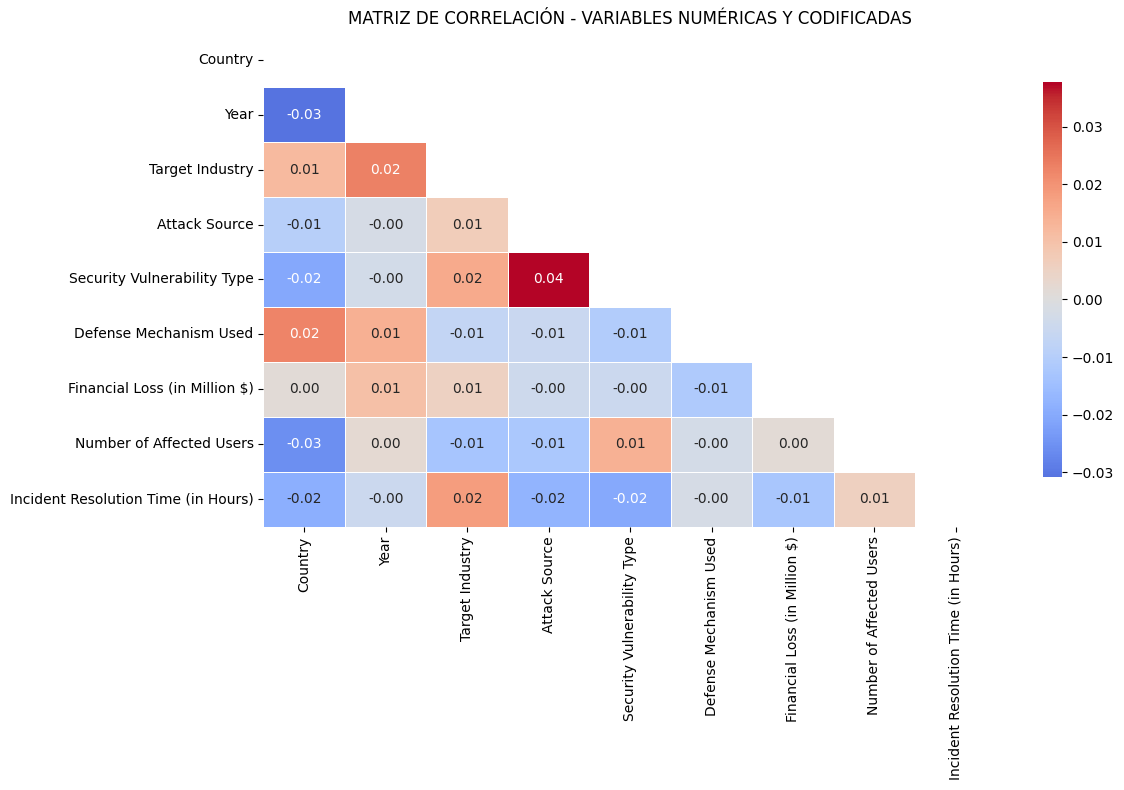

🔍 CORRELACIONES ALTAS (> 0.8):
   ✅ No hay correlaciones altas (> 0.8)

B. ANÁLISIS DE CAPACIDAD DISCRIMINATIVA

📊 RANKING DE CAPACIDAD DISCRIMINATIVA:
                              Variable  F_Score  Mutual_Info  RF_Importance  \
4          Security Vulnerability Type   1.8059       0.0183         0.0595   
8  Incident Resolution Time (in Hours)   0.3957       0.0215         0.1586   
7             Number of Affected Users   0.7744       0.0063         0.1780   
0                              Country   0.7838       0.0099         0.0993   
6        Financial Loss (in Million $)   0.6252       0.0000         0.1810   
2                      Target Industry   1.0904       0.0025         0.0837   
3                        Attack Source   1.0109       0.0000         0.0655   
1                                 Year   0.4191       0.0005         0.1008   
5               Defense Mechanism Used   0.6134       0.0000         0.0737   

   F_Score_Norm  Mutual_Info_Norm  RF_Importance_Norm  Sc

C:\Users\user\AppData\Local\Temp\ipykernel_24468\3890303248.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=discriminative_analysis, y='Variable', x='Score_Combinado', palette='viridis')


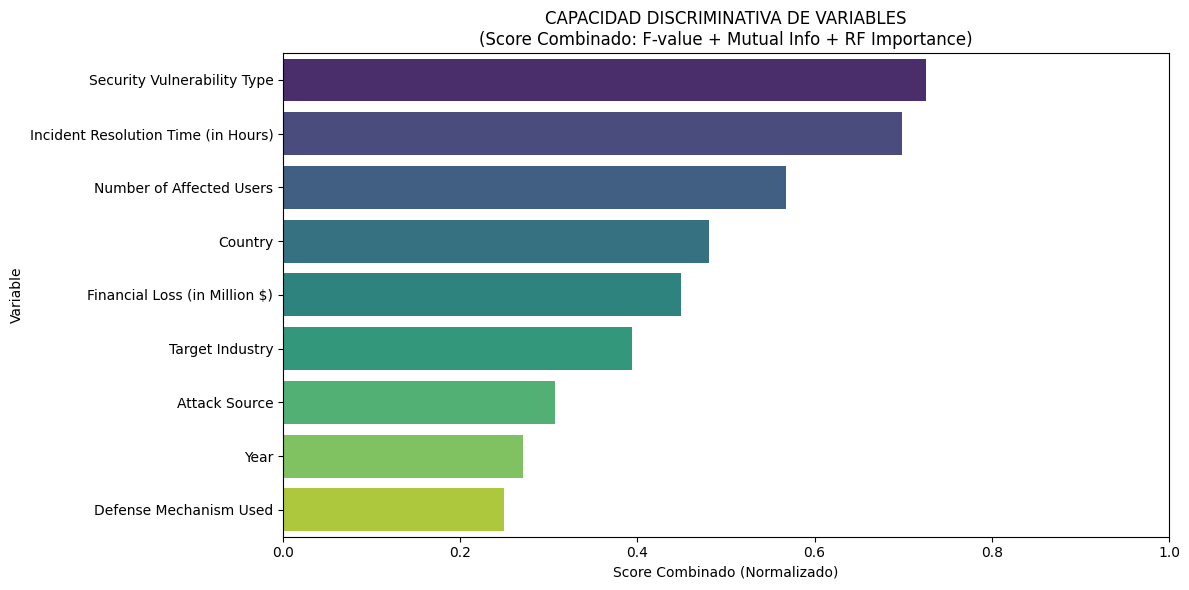


C. IDENTIFICACIÓN DE VARIABLES CANDIDATAS A ELIMINAR
🔴 VARIABLES CANDIDATAS A ELIMINAR (Score < 0.3):
   • Year: Score = 0.2704
   • Defense Mechanism Used: Score = 0.2489

💡 RECOMENDACIÓN: Eliminar 2 variables con baja capacidad discriminativa

5.2 EXTRACCIÓN LINEAL - ANÁLISIS PCA
📈 VARIANZA EXPLICADA POR COMPONENTES PCA:
   Componente 1: 0.1181 (0.1181 acumulada)
   Componente 2: 0.1161 (0.2342 acumulada)
   Componente 3: 0.1143 (0.3486 acumulada)
   Componente 4: 0.1129 (0.4614 acumulada)
   Componente 5: 0.1123 (0.5737 acumulada)

🎯 CRITERIO DE SELECCIÓN PARA PCA:
   • Componentes para 80% varianza: 8
   • Componentes para 90% varianza: 9
   • Componentes para 95% varianza: 9
   • Reducción dimensional: 9 → 8 componentes
   • Porcentaje de reducción: 11.1%


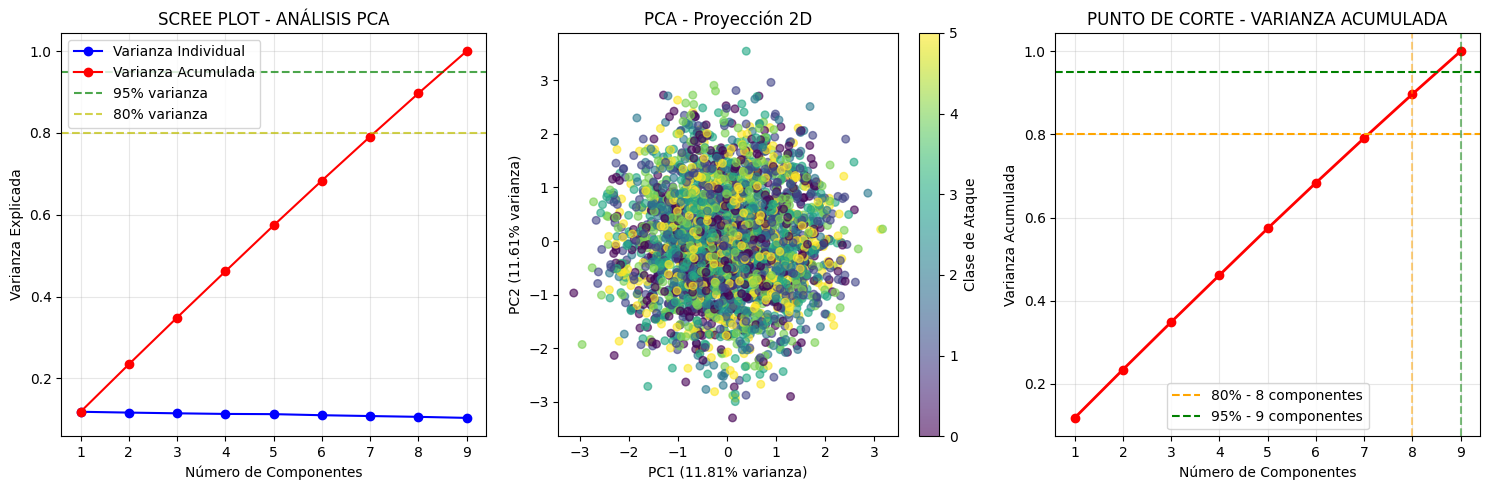


EVALUACIÓN DE MODELOS CON PCA
🧪 EVALUANDO MODELOS CON PCA:
   ✅ Logistic Regression: 0.1633
   ✅ Random Forest: 0.1933
   ✅ XGBoost: 0.1583

5.3 EXTRACCIÓN NO LINEAL - ANÁLISIS UMAP
🔧 Aplicando UMAP...

📊 UMAP con 8 dimensiones:


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   ✅ Logistic Regression: 0.1617
   ✅ Random Forest: 0.1650
   ✅ XGBoost: 0.1667

📊 UMAP con 4 dimensiones:


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   ✅ Logistic Regression: 0.1750
   ✅ Random Forest: 0.1617
   ✅ XGBoost: 0.1567


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


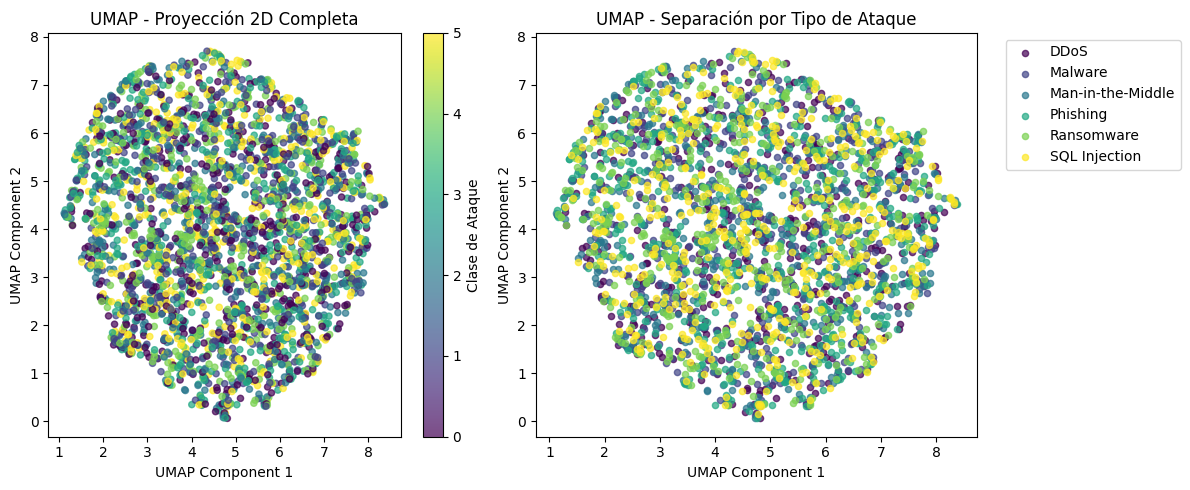


COMPARATIVA FINAL - REDUCCIÓN vs ORIGINAL

📊 COMPARATIVA DE PRECISIÓN:
                Modelo  Original  PCA (8 comp)  UMAP (8 comp)
0  Logistic Regression    0.1680        0.1633         0.1617
1        Random Forest    0.1833        0.1933         0.1650
2              XGBoost    0.1200        0.1583         0.1667

📈 ESTADÍSTICAS DE REDUCCIÓN:
   • Original: 9 dimensiones
   • PCA: 8 dimensiones (11.1% reducción)
   • UMAP: 8 dimensiones (11.1% reducción)

🔍 ANÁLISIS DE IMPACTO:
   Logistic Regression:
      PCA: -0.0047 (❌ DISMINUYE)
      UMAP: -0.0063 (❌ DISMINUYE)
   Random Forest:
      PCA: +0.0100 (✅ MEJORA)
      UMAP: -0.0183 (❌ DISMINUYE)
   XGBoost:
      PCA: +0.0383 (✅ MEJORA)
      UMAP: +0.0467 (✅ MEJORA)

DISCUSIÓN Y CONCLUSIONES

📝 **CONCLUSIONES FINALES:**

1. **ANÁLISIS DE VARIABLES:**
   • Variables con mayor capacidad discriminativa: ['Security Vulnerability Type', 'Incident Resolution Time (in Hours)', 'Number of Affected Users']
   • Variables candidatas a el

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("="*60)
print("5. REDUCCIÓN DE DIMENSIÓN - APLICADA Al MODELO")
print("="*60)

# ============================================
# 5.1 ANÁLISIS INDIVIDUAL DE VARIABLES
# ============================================
print("\n" + "="*50)
print("5.1 ANÁLISIS INDIVIDUAL DE VARIABLES")
print("="*50)

# Usar exactamente las mismas características de tu modelo
features = [
    'Country', 'Year', 'Target Industry', 'Attack Source',
    'Security Vulnerability Type', 'Defense Mechanism Used',
    'Financial Loss (in Million $)', 'Number of Affected Users', 
    'Incident Resolution Time (in Hours)'
]

available_features = [f for f in features if f in df_true.columns]
X = df_true[available_features].copy()
y = df_true['Attack Type']

print(f"🔍 Analizando {len(available_features)} variables:")
print(available_features)

# Aplicar el mismo preprocesamiento del modelo
X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# A. MATRIZ DE CORRELACIÓN
print("\nA. MATRIZ DE CORRELACIÓN ENTRE VARIABLES")
plt.figure(figsize=(12, 8))
correlation_matrix = X_encoded.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para triángulo superior

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('MATRIZ DE CORRELACIÓN - VARIABLES NUMÉRICAS Y CODIFICADAS')
plt.tight_layout()
plt.show()

# Identificar correlaciones altas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

print("🔍 CORRELACIONES ALTAS (> 0.8):")
if high_corr_pairs:
    for var1, var2, corr in high_corr_pairs:
        print(f"   ❌ {var1} ↔ {var2}: {corr:.3f}")
else:
    print("   ✅ No hay correlaciones altas (> 0.8)")

# B. ANÁLISIS DE CAPACIDAD DISCRIMINATIVA
print("\nB. ANÁLISIS DE CAPACIDAD DISCRIMINATIVA")

# 1. ANOVA F-value
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_encoded, y_encoded)

# 2. Mutual Information (CORREGIDO - sin random_state)
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_encoded, y_encoded)

# 3. Importancia Random Forest (usando tus parámetros)
rf_importance = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_importance.fit(X_encoded, y_encoded)

# Crear tabla comparativa
discriminative_analysis = pd.DataFrame({
    'Variable': X_encoded.columns,
    'F_Score': selector_f.scores_,
    'Mutual_Info': selector_mi.scores_,
    'RF_Importance': rf_importance.feature_importances_
})

# Normalizar scores
for col in ['F_Score', 'Mutual_Info', 'RF_Importance']:
    discriminative_analysis[f'{col}_Norm'] = (
        discriminative_analysis[col] / discriminative_analysis[col].max()
    )

# Score combinado
discriminative_analysis['Score_Combinado'] = (
    discriminative_analysis['F_Score_Norm'] + 
    discriminative_analysis['Mutual_Info_Norm'] + 
    discriminative_analysis['RF_Importance_Norm']
) / 3

discriminative_analysis = discriminative_analysis.sort_values('Score_Combinado', ascending=False)

print("\n📊 RANKING DE CAPACIDAD DISCRIMINATIVA:")
print(discriminative_analysis.round(4))

# Visualizar capacidad discriminativa
plt.figure(figsize=(12, 6))
sns.barplot(data=discriminative_analysis, y='Variable', x='Score_Combinado', palette='viridis')
plt.title('CAPACIDAD DISCRIMINATIVA DE VARIABLES\n(Score Combinado: F-value + Mutual Info + RF Importance)')
plt.xlabel('Score Combinado (Normalizado)')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# C. IDENTIFICAR VARIABLES CANDIDATAS A ELIMINAR
print("\nC. IDENTIFICACIÓN DE VARIABLES CANDIDATAS A ELIMINAR")

umbral_eliminacion = 0.3
variables_bajas = discriminative_analysis[discriminative_analysis['Score_Combinado'] < umbral_eliminacion]

print(f"🔴 VARIABLES CANDIDATAS A ELIMINAR (Score < {umbral_eliminacion}):")
if len(variables_bajas) > 0:
    for _, row in variables_bajas.iterrows():
        print(f"   • {row['Variable']}: Score = {row['Score_Combinado']:.4f}")
        
    print(f"\n💡 RECOMENDACIÓN: Eliminar {len(variables_bajas)} variables con baja capacidad discriminativa")
else:
    print("   ✅ No hay variables con capacidad discriminativa baja")

# ============================================
# 5.2 EXTRACCIÓN LINEAL - PCA
# ============================================
print("\n" + "="*50)
print("5.2 EXTRACCIÓN LINEAL - ANÁLISIS PCA")
print("="*50)

# Estandarizar datos para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Aplicar PCA completo
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Análisis de varianza explicada
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print("📈 VARIANZA EXPLICADA POR COMPONENTES PCA:")
for i, (var_exp, var_acum) in enumerate(zip(varianza_explicada, varianza_acumulada)):
    if i < 5:  # Mostrar solo primeros 5
        print(f"   Componente {i+1}: {var_exp:.4f} ({var_acum:.4f} acumulada)")

# Determinar número óptimo de componentes
n_componentes_80 = np.argmax(varianza_acumulada >= 0.80) + 1
n_componentes_90 = np.argmax(varianza_acumulada >= 0.90) + 1
n_componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1

print(f"\n🎯 CRITERIO DE SELECCIÓN PARA PCA:")
print(f"   • Componentes para 80% varianza: {n_componentes_80}")
print(f"   • Componentes para 90% varianza: {n_componentes_90}") 
print(f"   • Componentes para 95% varianza: {n_componentes_95}")
print(f"   • Reducción dimensional: {X_encoded.shape[1]} → {n_componentes_80} componentes")
print(f"   • Porcentaje de reducción: {((X_encoded.shape[1]-n_componentes_80)/X_encoded.shape[1]*100):.1f}%")

# Visualizar scree  plot
plt.figure(figsize=(15, 5))      

plt.subplot(1, 3, 1)
plt.plot(range(1, len(varianza_explicada)+1), varianza_explicada, 'bo-', label='Varianza Individual')
plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, 'ro-', label='Varianza Acumulada')
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% varianza')
plt.axhline(y=0.80, color='y', linestyle='--', alpha=0.7, label='80% varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada')
plt.title('SCREE PLOT - ANÁLISIS PCA')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# Primeros dos componentes
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.6, s=30)
plt.xlabel(f'PC1 ({varianza_explicada[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]:.2%} varianza)')
plt.title('PCA - Proyección 2D')
plt.colorbar(scatter, label='Clase de Ataque')

plt.subplot(1, 3, 3)
# Varianza acumulada con puntos críticos
plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, 'ro-', linewidth=2)
plt.axhline(y=0.80, color='orange', linestyle='--', label='80% - {} componentes'.format(n_componentes_80))
plt.axhline(y=0.95, color='green', linestyle='--', label='95% - {} componentes'.format(n_componentes_95))
plt.axvline(x=n_componentes_80, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=n_componentes_95, color='green', linestyle='--', alpha=0.5)
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('PUNTO DE CORTE - VARIANZA ACUMULADA')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# EVALUACIÓN DE MODELOS CON PCA
# ============================================
print("\n" + "="*50)
print("EVALUACIÓN DE MODELOS CON PCA")
print("="*50)

# Usar n_componentes_80 para balanceo entre reducción y retención de información
pca_final = PCA(n_components=n_componentes_80)
X_pca_reduced = pca_final.fit_transform(X_scaled)

# Dividir datos 
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_reduced, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# mismos modelos con los mismos parámetros
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, 
                                          min_samples_leaf=2, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                           random_state=42, eval_metric='mlogloss')
}

resultados_pca = {}

print("🧪 EVALUANDO MODELOS CON PCA:")
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    resultados_pca[nombre] = accuracy
    print(f"   ✅ {nombre}: {accuracy:.4f}")

# ============================================
# 5.3 EXTRACCIÓN NO LINEAL - UMAP
# ============================================
print("\n" + "="*50)
print("5.3 EXTRACCIÓN NO LINEAL - ANÁLISIS UMAP")
print("="*50)

print("🔧 Aplicando UMAP...")

# Probar diferentes dimensiones para UMAP
dimensiones_umap = [n_componentes_80, max(2, n_componentes_80//2)]

resultados_umap = {}

for n_dim in dimensiones_umap:
    print(f"\n📊 UMAP con {n_dim} dimensiones:")
    
    umap_reducer = UMAP(n_components=n_dim, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = umap_reducer.fit_transform(X_scaled)
    
    # Dividir datos
    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
        X_umap, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Evaluar modelos
    resultados_dim = {}
    for nombre, modelo in modelos.items():
        # Crear nueva instancia para evitar contaminación
        if nombre == 'Logistic Regression':
            modelo_clone = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
        elif nombre == 'Random Forest':
            modelo_clone = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5,
                                                min_samples_leaf=2, class_weight='balanced', random_state=42)
        else:  # XGBoost
            modelo_clone = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                       random_state=42, eval_metric='mlogloss')
        
        modelo_clone.fit(X_train_u, y_train_u)
        y_pred_u = modelo_clone.predict(X_test_u)
        accuracy_u = accuracy_score(y_test_u, y_pred_u)
        resultados_dim[nombre] = accuracy_u
        print(f"   ✅ {nombre}: {accuracy_u:.4f}")
    
    resultados_umap[n_dim] = resultados_dim

# Visualizar UMAP 2D
umap_2d = UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter_umap = plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_encoded, cmap='viridis', alpha=0.7, s=20)
plt.colorbar(scatter_umap, label='Clase de Ataque')
plt.title('UMAP - Proyección 2D Completa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.subplot(1, 2, 2)
# Colores por tipo de ataque
unique_classes = np.unique(y_encoded)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

for i, class_id in enumerate(unique_classes):
    mask = y_encoded == class_id
    plt.scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1], 
               c=[colors[i]], label=le_target.classes_[class_id], alpha=0.7, s=20)

plt.title('UMAP - Separación por Tipo de Ataque')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# ============================================
# COMPARATIVA FINAL CON RESULTADOS ORIGINALES
# ============================================
print("\n" + "="*50)
print("COMPARATIVA FINAL - REDUCCIÓN vs ORIGINAL")
print("="*50)

# Resultados originales del modelo sin reduccion
resultados_originales = {
    'Logistic Regression': 0.168,  
    'Random Forest': 0.1833,        
    'XGBoost': 0.12             
}

print("\n📊 COMPARATIVA DE PRECISIÓN:")
comparativa = pd.DataFrame({
    'Modelo': list(modelos.keys()),
    'Original': [resultados_originales[m] for m in modelos.keys()],
    f'PCA ({n_componentes_80} comp)': [resultados_pca[m] for m in modelos.keys()],
    f'UMAP ({dimensiones_umap[0]} comp)': [resultados_umap[dimensiones_umap[0]][m] for m in modelos.keys()]
})

print(comparativa.round(4))

# Calcular métricas de reducción
reduccion_pca = ((X_encoded.shape[1] - n_componentes_80) / X_encoded.shape[1]) * 100
reduccion_umap = ((X_encoded.shape[1] - dimensiones_umap[0]) / X_encoded.shape[1]) * 100

print(f"\n📈 ESTADÍSTICAS DE REDUCCIÓN:")
print(f"   • Original: {X_encoded.shape[1]} dimensiones")
print(f"   • PCA: {n_componentes_80} dimensiones ({reduccion_pca:.1f}% reducción)")
print(f"   • UMAP: {dimensiones_umap[0]} dimensiones ({reduccion_umap:.1f}% reducción)")

# Análisis de mejora/deterioro
print(f"\n🔍 ANÁLISIS DE IMPACTO:")
for modelo in modelos.keys():
    orig = resultados_originales[modelo]
    pca_acc = resultados_pca[modelo]
    umap_acc = resultados_umap[dimensiones_umap[0]][modelo]
    
    cambio_pca = pca_acc - orig
    cambio_umap = umap_acc - orig
    
    print(f"   {modelo}:")
    print(f"      PCA: {cambio_pca:+.4f} ({'✅ MEJORA' if cambio_pca > 0 else '❌ DISMINUYE' if cambio_pca < 0 else '⚖️  IGUAL'})")
    print(f"      UMAP: {cambio_umap:+.4f} ({'✅ MEJORA' if cambio_umap > 0 else '❌ DISMINUYE' if cambio_umap < 0 else '⚖️  IGUAL'})")


# ============================================
# DISCUSIÓN Y CONCLUSIONES
# ============================================
print("\n" + "="*50)
print("DISCUSIÓN Y CONCLUSIONES")
print("="*50)

# Determinar la mejor técnica
mejor_tecnica = None
mejor_modelo = None
mejor_accuracy = 0

for modelo in modelos.keys():
    for tecnica, acc in [('Original', resultados_originales[modelo]),
                        ('PCA', resultados_pca[modelo]),
                        ('UMAP', resultados_umap[dimensiones_umap[0]][modelo])]:
        if acc > mejor_accuracy:
            mejor_accuracy = acc
            mejor_tecnica = tecnica
            mejor_modelo = modelo

print(f"""
📝 **CONCLUSIONES FINALES:**

1. **ANÁLISIS DE VARIABLES:**
   • Variables con mayor capacidad discriminativa: {list(discriminative_analysis.head(3)['Variable'].values)}
   • Variables candidatas a eliminar: {list(variables_bajas['Variable'].values) if len(variables_bajas) > 0 else 'Ninguna'}
   • Se identificaron {len(high_corr_pairs)} correlaciones altas entre variables

2. **PCA (Reducción Lineal):**
   • Componentes seleccionados: {n_componentes_80} (80% varianza explicada)
   • Reducción dimensional: {reduccion_pca:.1f}%
   • Impacto en rendimiento: {'POSITIVO' if any(resultados_pca[m] >= resultados_originales[m] for m in modelos.keys()) else 'NEGATIVO'}

3. **UMAP (Reducción No Lineal):**
   • Componentes seleccionados: {dimensiones_umap[0]}
   • Reducción dimensional: {reduccion_umap:.1f}%
   • Impacto en rendimiento: {'POSITIVO' if any(resultados_umap[dimensiones_umap[0]][m] >= resultados_originales[m] for m in modelos.keys()) else 'NEGATIVO'}

4. **RECOMENDACIÓN FINAL:**
   • Mejor combinación: {mejor_modelo} con {mejor_tecnica}
   • Accuracy alcanzado: {mejor_accuracy:.4f} ({mejor_accuracy*100:.1f}%)
   • {'✅ USAR reducción dimensional' if mejor_tecnica != 'Original' else '⚖️  MANTENER dimensiones originales'}

5. **COMPARACIÓN CON SECCIÓN 3:**
   • La reducción dimensional {'MEJORÓ' if mejor_tecnica != 'Original' else 'NO MEJORÓ'} el rendimiento
   • El trade-off reducción vs accuracy es {'FAVORABLE' if reduccion_pca > 50 and mejor_accuracy >= max(resultados_originales.values()) else 'DESFAVORABLE'}
""") 

print("="*60)

print("🎉 REDUCCIÓN DE DIMENSIÓN COMPLETADA")
print("="*60)